# Predicting Taxi Ride Durations

# Introduction

The aim of this project is to create model that is capable of predicting the approximate trip duration of a taxi ride in New York city. This challenge and dataset was provided by Kaggle as one of their competitions. This will be a regression problem as the output will be in seconds (time). The competition states that the evalution metric for this problem should be Root Mean Square Logarithmic Error (RMSLE).

Import dependencies.

In [1]:
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb

# Exploring the Data
* __id__ - identification number of each taxi trip
* __vendor_id__ - taxi company of which there are 2. Classified as 1 and 2
* __pickup_datetime__ - time and date of passenger pickup
* __dropoff_datetime__ - time and date of passenger drop off
* __passenger_count__ - number of passengers in the taxi
* __pickup_longitude__ - longitude coorindates of passenger pickup 
* __pickup_latitude__ - latiitude coorindates of passenger pickup 
* __dropoff_longitude__ - longitude coorindates of passenger dropoff
* __dropoff_latitude__ - latitude coorindates of passenger dropoff 

In [2]:
dataset = pd.read_csv("./taxifare/train.csv")
dataset.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


A quick checkt to see if there is any missing data in the csv file.

In [3]:
dataset.isnull().values.any()

False

We can we that the max trip_duration does not seem very plassilable and is quite clearly an outlier. Trip_duration has a normal/Guassian distribution. 

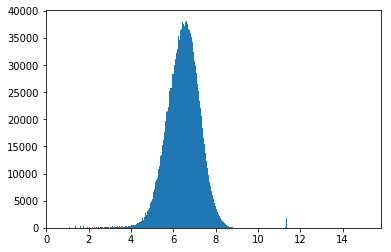

Trip_duration mean: 959.49
Trip_duration max: 3526282.00
Trip_duration min: 1.00


In [4]:
plt.figure()
plt.hist(np.log(dataset['trip_duration'].values+1), bins=300)
plt.show()
print("Trip_duration mean: %.2f\nTrip_duration max: %.2f\nTrip_duration min: %.2f" % (dataset['trip_duration'].mean(), dataset['trip_duration'].max(), dataset['trip_duration'].min()))

We see that the max trip duration is very large and probably a mistake(3526282 seconds = 979 hours!). Also the minimum value of 1 second is not relevant and will not help with predictions. Those values should not effect the model preformance as the output will be logarithmic.

The trip_duration values that are over 86400 seconds (24 hours) are clearly a mistake in data collection and should be removed. It is safe to assume that there will be not taxi rides over 24 hours in New York city

In [5]:
dataset[dataset['trip_duration'] > (86400)].count() 

id                    4
vendor_id             4
pickup_datetime       4
dropoff_datetime      4
passenger_count       4
pickup_longitude      4
pickup_latitude       4
dropoff_longitude     4
dropoff_latitude      4
store_and_fwd_flag    4
trip_duration         4
dtype: int64

In [6]:
dataset = dataset.drop(dataset[dataset.trip_duration>(86400)].index) #row with trip_duration over 86400 are removed

The distance will obviously be an important feature in the time of the taxi journey. The Haverine distance formula is the straight line distance (as the crow flies) between two points of latitude and longitude. This is used in the distance_h function. 
The distance function is used to calculate the 'real' distance the car travels as it has to follow the roads. Fortunately the American city grid system allows to easily estimate the distance the taxi travelled. However if the taxi travels in a straight line without taking any turns, the Haverine distance and the 'real' distance will be the same value.

In [7]:
def distance_h(long1,long2,lat1, lat2):
    x1, x2, y1, y2 = np.radians(long1),np.radians(long2), np.radians(lat1),np.radians(lat2)
    delta_long = x2 - x1
    delta_lat = y2 - y1
    earth_radius = 6371     # in km
    #haversine
    a = np.sin(delta_lat*0.5)**2 + np.cos(y1)*np.cos(y2)*(np.sin(delta_long*0.5)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = earth_radius*c
    return d

def distance(long1, long2, lat1, lat2):
    f1 = distance_h(long1,long1, lat1, lat2)
    f2 = distance_h(long1, long2, lat1, lat1)
    return f1+f2

In [8]:
dataset.loc[:,'distance_h'] = distance_h(dataset['pickup_longitude'].values,dataset['dropoff_longitude'].values , dataset['pickup_latitude'].values, dataset['dropoff_latitude'].values)

Similarly there are outliers in the coorindates. We see that the max distance is 1240 km which is very large compared to the mean of 3.44km. We also see that the min distance is 0.00 which is not helpful for making prediction and must be an error in measurement. 

In [9]:
print("Distance mean: %.2f\nDistance max: %.2f\nDistance min: %.2f" % (dataset['distance_h'].mean(), dataset['distance_h'].max(), dataset['distance_h'].min()))

Distance mean: 3.44
Distance max: 1240.91
Distance min: 0.00


In [10]:
dataset.loc[:,'distance'] = distance(dataset['pickup_longitude'].values,dataset['dropoff_longitude'].values , dataset['pickup_latitude'].values, dataset['dropoff_latitude'].values)

There is a correlation of 0.1519 between trip_duration and distance. On long open roads this relationship would be close to 1 but this show the unpredictablity of New York traffic, weather, etc. 

Correlation between trip_duration and distance:  [[1.         0.15191638]
 [0.15191638 1.        ]]


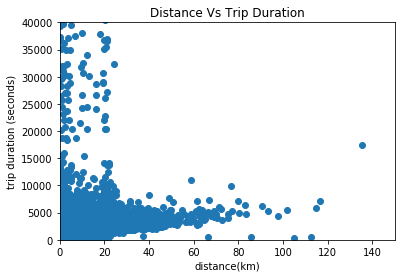

In [11]:
plt.figure()
plt.scatter(dataset['distance_h'], dataset['trip_duration'])
plt.xlabel('distance(km)')
plt.ylabel('trip duration (seconds)')
plt.title('Distance Vs Trip Duration')
plt.ylim(0,40000)
plt.xlim(0,150)

corr = np.corrcoef(dataset['trip_duration'], dataset['distance_h'])

print("Correlation between trip_duration and distance: ", corr)

The speed is calculated to provide usful data when looking at traffic in different areas. Of course the speed could not be used as a feature in the model. If the speed and distance was given as features then the model would be a simple calcultor to divide eachother to find the trip duration. 

In [12]:
def speed(distance, time):
    t = (time/60)/60
    spe = distance/t
    return spe

In [13]:
dataset.loc[:,'speed'] = speed(dataset['distance'].values, dataset['trip_duration'].values)

The direction could also be an important feature. The trafic can be greater in traveling to the centre or away from the centre of the city at different times. 

In [14]:
def direction(a_long, b_long, a_lat, b_lat):
    a_lat, b_lat = np.radians(a_lat), np.radians(b_lat)
    delta_long = np.radians(b_long - a_long)
    
    f1 = np.cos(b_lat)*np.sin(delta_long)
    f2 = np.cos(a_lat)*np.sin(b_lat)-np.sin(a_lat)*np.cos(b_lat)*np.cos(delta_long)
    
    beta = np.arctan2(f1, f2)
    return np.degrees(beta)

In [15]:
dataset.loc[:,'direction'] = direction(dataset['pickup_longitude'].values,dataset['dropoff_longitude'].values , dataset['pickup_latitude'].values, dataset['dropoff_latitude'].values)                                       

The time and date is extracted from pickup_datetime as usable integers for hour of the hour, day of the week and week of the year. Hour of the day is represented from 0 to 23. Day of the week is represented as 0 to 6 (0 being Sunday). and 0 to 51 for week of the year.

In [16]:
dataset['pickup_datetime'] = pd.to_datetime(dataset.pickup_datetime)
dataset.loc[:, 'pickup_hour'] = dataset['pickup_datetime'].dt.hour
dataset.loc[:, 'pickup_weekday'] = dataset['pickup_datetime'].dt.weekday
dataset.loc[:, 'pickup_weekofyear'] = dataset['pickup_datetime'].dt.weekofyear

The hour of day, day of week and month of year are plotted against speed to investiagte traffic are different times of the day. The data shows that the hour of the day has the most significant effect of average speed compared to the other two time features. The days of the week also showing a reduction in speed from Monday to Thursday.

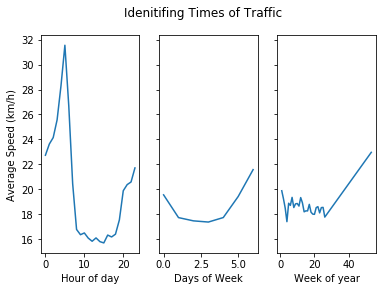

In [17]:
fig, ax = plt.subplots(ncols = 3, sharey=True)
ax[0].plot(dataset.groupby('pickup_hour').mean()['speed'])
ax[1].plot(dataset.groupby('pickup_weekday').mean()['speed'])
ax[2].plot(dataset.groupby('pickup_weekofyear').mean()['speed'])
ax[0].set_ylabel('Average Speed (km/h)')
ax[0].set_xlabel('Hour of day')
ax[1].set_xlabel('Days of Week')
ax[2].set_xlabel('Week of year')
fig.suptitle('Idenitifing Times of Traffic')
plt.show()

The model should know the pickup and drop off position of the taxi. Latitude and longitude are useful but representing the areas might provide insight to the pickup and drop off data. Therefore the pickup and drop off position are clusttered. This forms seperate areas which nearby pickup and drop off occur. The pickup and drop off coordinates are combined as there should not be seperate areas for the two sets of coordinates. 

Kmeans clustering is used to fit the data in 100 seperate areas. 

In [18]:
coords =  np.vstack((dataset[['pickup_latitude', 'pickup_longitude']].values, dataset[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size = 10000).fit(coords[sample_ind])

In [19]:
dataset.loc[:,'pickup_cluster'] = kmeans.predict(dataset[['pickup_latitude', 'pickup_longitude']])
dataset.loc[:,'dropoff_cluster'] = kmeans.predict(dataset[['dropoff_latitude', 'dropoff_longitude']])


The city boarders longitude and latitude are used to scale the graph. The longitude and latitude of pickup and drop off outline all the roads of New York. Colouring the clusters 'winter' colours allows to see the areas mapped out. 

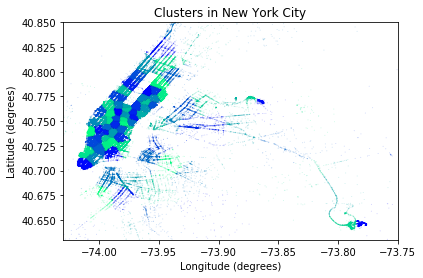

In [20]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure()
plt.scatter(dataset.pickup_longitude.values[:500000], dataset.pickup_latitude.values[:500000],
           s=1, lw=0, c = dataset.pickup_cluster[:500000].values,cmap='winter', alpha=0.2)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Clusters in New York City')
plt.show()

Some colunms in the dataset are not needed for modelling. Features like vendor_id and store_and_fwd_flag are not relevant to the trip_duration. 

In [21]:
print(dataset.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_h', 'distance', 'speed', 'direction',
       'pickup_hour', 'pickup_weekday', 'pickup_weekofyear', 'pickup_cluster',
       'dropoff_cluster'],
      dtype='object')


The features that will be used for training the model 
* pickup_longitude & pickup_latitude
* dropoff_longitude & dropoff_latitude
* distance_h
* distance
* direction
* pickup_hour & pickup_weekday & pickup_weekofyear
* pickup_cluster & dropoff_cluster

In [22]:
X = dataset.iloc[:,[5,6,7,8,11,12,14,15,16,17,18,19]]
y = np.log(dataset['trip_duration'].values + 1)
print(X.columns)

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'distance_h', 'distance', 'direction',
       'pickup_hour', 'pickup_weekday', 'pickup_weekofyear', 'pickup_cluster',
       'dropoff_cluster'],
      dtype='object')


The data is split into training and testing data with an 80/20 split. 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Xgboost is used for modelling for its speed and its precision. I did change the parameters a few times to find what was performing the best. 

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 50, 'eta': 0.5, 'colsample_bytree': 0.9, 'max_depth': 10,
            'subsample': 0.9, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 60, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)


[0]	train-rmse:3.0381	valid-rmse:3.03715
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.390394	valid-rmse:0.402031
[20]	train-rmse:0.381379	valid-rmse:0.39806
[30]	train-rmse:0.375376	valid-rmse:0.396341
[40]	train-rmse:0.371036	valid-rmse:0.396003
[50]	train-rmse:0.367502	valid-rmse:0.395911
[59]	train-rmse:0.36505	valid-rmse:0.395994


We can see that the model preformed well. The best vaild-rmse is 0.395768. This is a good score considering the range of the output (0.69 to 11.36) and given the dataset. 
Below is a graph showing which of the features are most important according to their f score. 

In [25]:
best_rmse = model.best_score
print("Best valid-rmsle = %f" %best_rmse)

Best valid-rmsle = 0.395767


Below is a graph showing which of the features are most important according to their f score. 

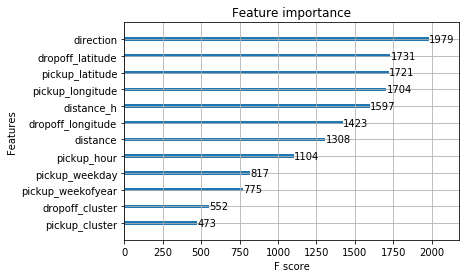

In [26]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5,5]
plt.show()

# Conclusion

From the feature importance graph we can see some interesting results. Direction had the biggest impact on trip duration. As stated previously, this maybe due to traffic heading in the direction towards the centre of the city is more dense than driving away from the city. Dropoff_latitude and pickup_latitude that has the largest impact on trip_duration. This must be due to areas being usual more traffic dense or less traffic dense. It is interesting to see that theses coordinates are more important than distance.

Distance was also of high importance but that should be obvious that it would have a large impact on the trip duration. Although this does raise concerns that the distance should be the most important. But this maybe due to the unpredictablity of New York traffic.

Pickup_hour was important to trip_duration. This should not be surprising see the average speed ploted against hour of the day had a range bewteen 16km/h to 32km/h at different times. 

To improve your predictability of New York taxis more features would be needed. To combine this dataset with traffic report data, weather data, roadworks data and parades. These features would have a huge effect on trip duration e.g. during rain or snow the taxi would drive slower, roadworks would cause delays etc.